<a href="https://colab.research.google.com/github/ubsuny/PHY386/blob/Homework2025/2025/HW/iamtomato761/HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 2: Data Analysis with pandas and NumPy

## Read data

In [20]:
# Upload the CSV file
from google.colab import files
uploaded = files.upload()

# Read the CSV using pandas
import pandas as pd

filename = list(uploaded.keys())[0]  # Automatically get the uploaded filename
df = pd.read_csv(filename)


Saving Raw Data.csv to Raw Data (1).csv


## (Part 4: Advanced Visualization)

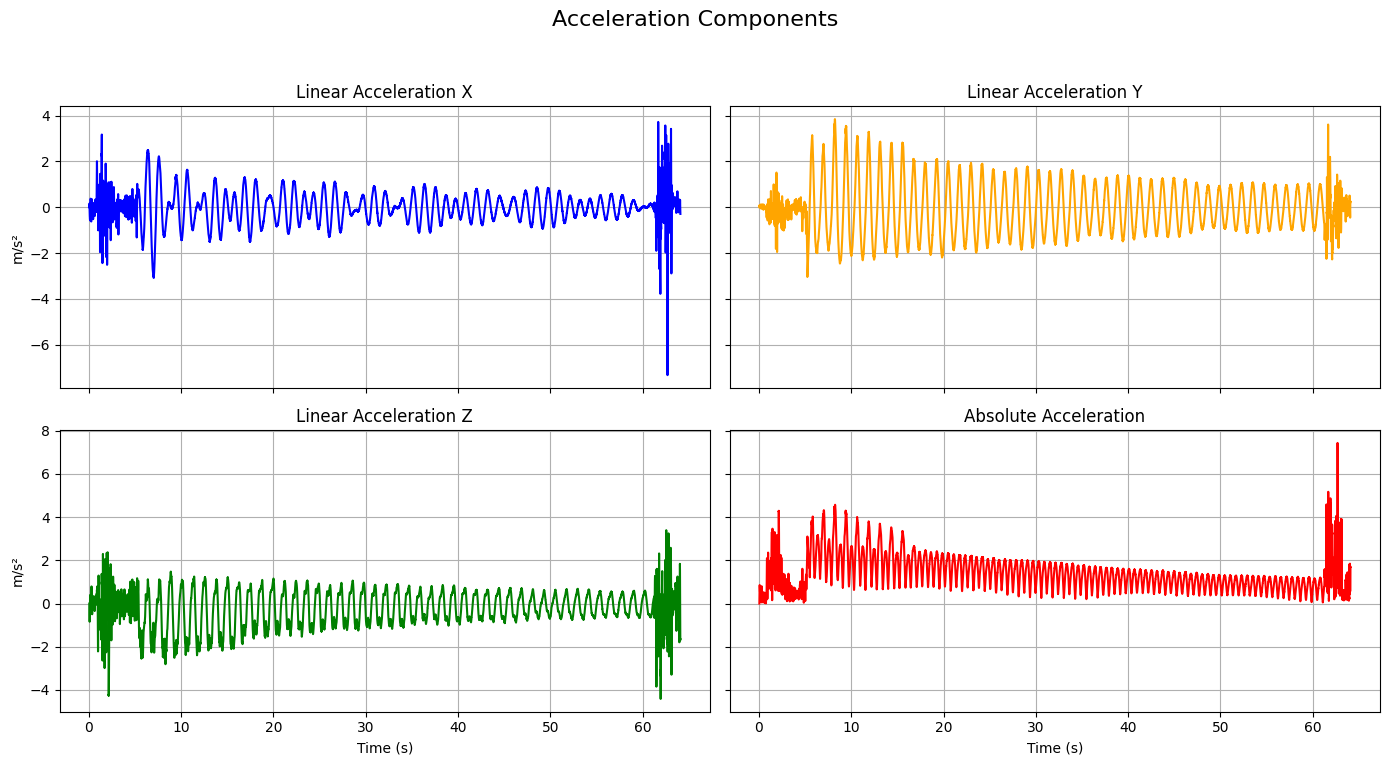

In [21]:
# Create a 2x2 grid for acceleration plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 8), sharex='col', sharey='row')
fig.suptitle('Acceleration Components', fontsize=16)

# Plot raw acceleration components
ax1.plot(df["Time (s)"], df["Linear Acceleration x (m/s^2)"], color='blue')
ax1.set_title("Linear Acceleration X")
ax1.set_ylabel("m/s²")

ax2.plot(df["Time (s)"], df["Linear Acceleration y (m/s^2)"], color='orange')
ax2.set_title("Linear Acceleration Y")

ax3.plot(df["Time (s)"], df["Linear Acceleration z (m/s^2)"], color='green')
ax3.set_title("Linear Acceleration Z")
ax3.set_ylabel("m/s²")
ax3.set_xlabel("Time (s)")

# Absolute acceleration in bottom right
ax4.plot(df["Time (s)"], df["Absolute acceleration (m/s^2)"], color='red')
ax4.set_title("Absolute Acceleration")
ax4.set_xlabel("Time (s)")

# Clean up labels
for ax in fig.get_axes():
    ax.label_outer()
    ax.grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


## Trimming

In [28]:
# trim
t_start = 6
t_end = 60

# Trim the data
df_trimmed = df[(df["Time (s)"] >= t_start) & (df["Time (s)"] <= t_end)].copy()

# Reset time so it starts at 0
df_trimmed["Time (s)"] -= df_trimmed["Time (s)"].iloc[0]

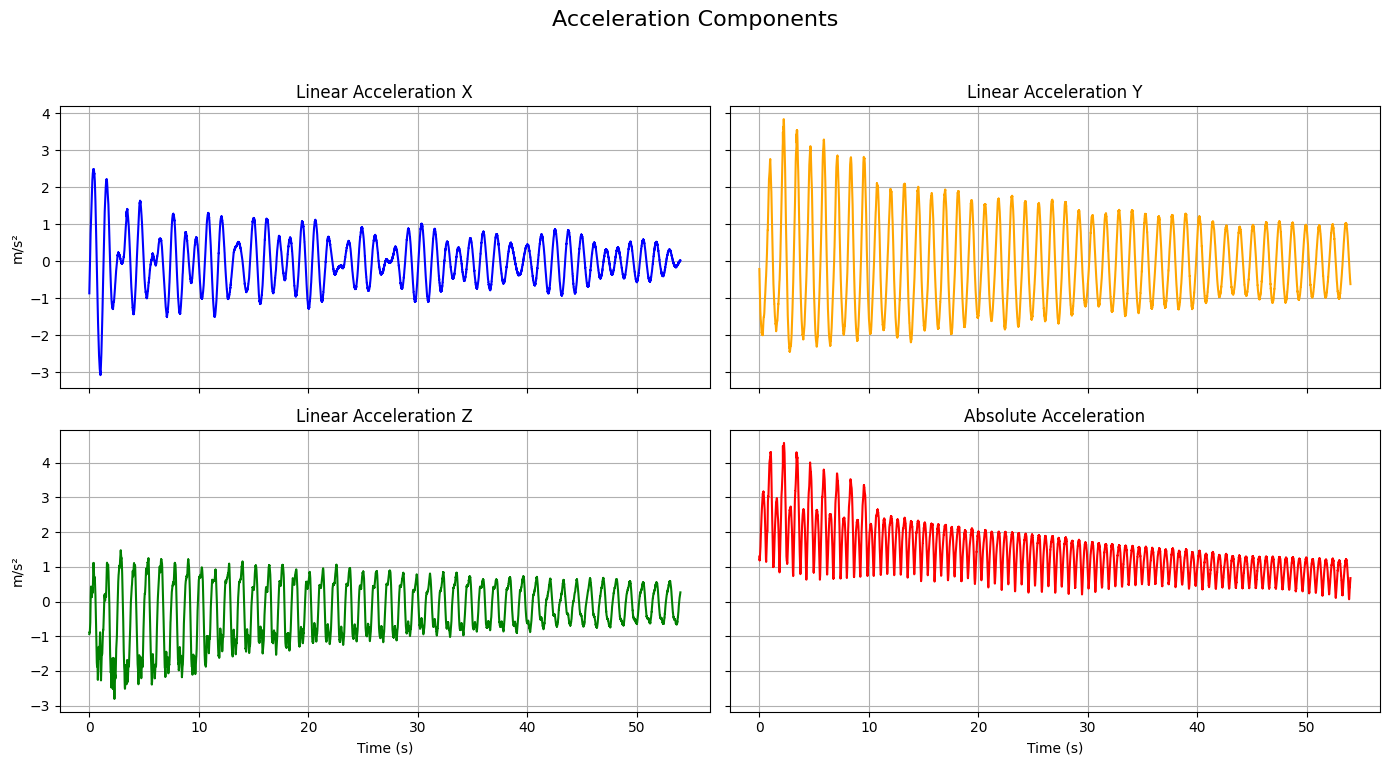

In [32]:
# Create a 2x2 grid for acceleration plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 8), sharex='col', sharey='row')
fig.suptitle('Acceleration Components', fontsize=16)

# Plot raw acceleration components
ax1.plot(df_trimmed["Time (s)"], df_trimmed["Linear Acceleration x (m/s^2)"], color='blue')
ax1.set_title("Linear Acceleration X")
ax1.set_ylabel("m/s²")

ax2.plot(df_trimmed["Time (s)"], df_trimmed["Linear Acceleration y (m/s^2)"], color='orange')
ax2.set_title("Linear Acceleration Y")

ax3.plot(df_trimmed["Time (s)"], df_trimmed["Linear Acceleration z (m/s^2)"], color='green')
ax3.set_title("Linear Acceleration Z")
ax3.set_ylabel("m/s²")
ax3.set_xlabel("Time (s)")

# Absolute acceleration in bottom right
ax4.plot(df_trimmed["Time (s)"], df_trimmed["Absolute acceleration (m/s^2)"], color='red')
ax4.set_title("Absolute Acceleration")
ax4.set_xlabel("Time (s)")

# Clean up labels
for ax in fig.get_axes():
    ax.label_outer()
    ax.grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Part 3: Model Fitting and Visualization

The **linear acceleration in the y-direction** displays the clearest and most symmetric oscillations. Compared to the x- and z-components, the y-axis signal is cleaner and more consistent, making it well-suited for fitting a damped oscillation model and extracting reliable physical parameters.

Let's fit y-direction!


In [76]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Time and acceleration
t = df_trimmed["Time (s)"].values
a = df_trimmed["Linear Acceleration y (m/s^2)"].values

# Find time at max |acceleration|
i_max = np.argmax(np.abs(a))
t_peak = t[i_max]

# Set window: start just before peak, end after
t_start = t_peak - 0.6
t_end = t_peak + 20

# Apply mask
mask = (t >= t_start) & (t <= t_end)
t_cut = t[mask]
a_cut = a[mask]

# Shift time so fit starts at t = 0
t_cut_zeroed = t_cut - t_cut[0]

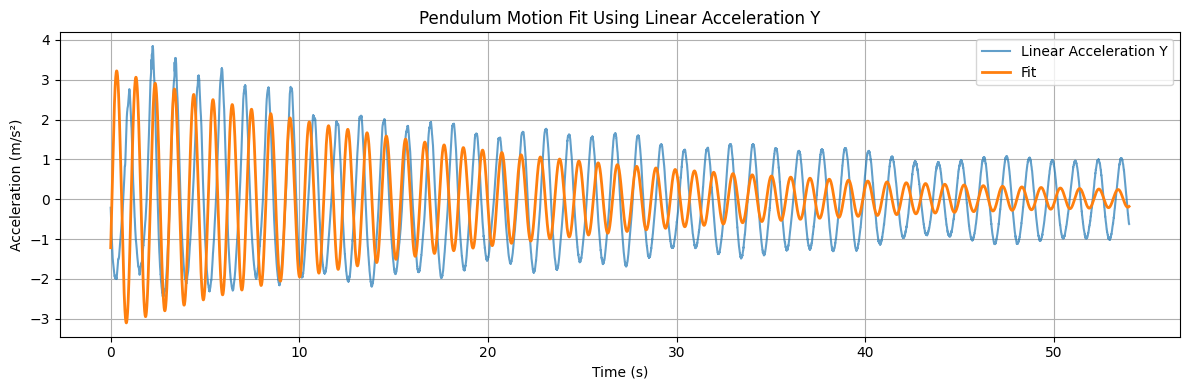

A (Amplitude) = 3.000 ± 0.105 m/s²
β (Damping coefficient) = 0.050 ± 0.004 1/s
ω (Angular frequency) = 6.153 ± 0.004 rad/s
ϕ (Phase offset) = 1.779 ± 0.035 rad
C (Offset) = 0.019 ± 0.030 m/s²


In [77]:
# Define damped oscillation with offset
def damped_oscillation(t, A, beta, omega, phi, C):
    return A * np.exp(-beta * t) * np.cos(omega * t + phi) + C

# Initial guess and bounds
guess = [4, 0.01, 6.5, 0, 0]
bounds = ([3, 0, 4, -np.pi, -5], [10, 0.05, 10, np.pi, 5])

# Fit
params, cov = curve_fit(damped_oscillation, t_cut_zeroed, a_cut, p0=guess, bounds=bounds)
A, beta, omega, phi, C = params
errors = np.sqrt(np.diag(cov))

# Plot
a_fit = damped_oscillation(t - t_cut[0], *params)
plt.figure(figsize=(12, 4))
plt.plot(t, a, label="Linear Acceleration Y", alpha=0.7)
plt.plot(t, a_fit, label="Fit", linewidth=2)
plt.xlabel("Time (s)")
plt.ylabel("Acceleration (m/s²)")
plt.title("Pendulum Motion Fit Using Linear Acceleration Y")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print results
print(f"A (Amplitude) = {A:.3f} ± {errors[0]:.3f} m/s²")
print(f"β (Damping coefficient) = {beta:.3f} ± {errors[1]:.3f} 1/s")
print(f"ω (Angular frequency) = {omega:.3f} ± {errors[2]:.3f} rad/s")
print(f"ϕ (Phase offset) = {phi:.3f} ± {errors[3]:.3f} rad")
print(f"C (Offset) = {C:.3f} ± {errors[4]:.3f} m/s²")


The fit was focused on the initial portion of the motion because the damping is most prominent during the first few seconds. After that, the oscillations appear to stabilize, with much slower decay. To capture the true damping behavior, I chose to fit only the early region where the energy loss is most apparent.

The y-component of acceleration was modeled using a damped cosine function. After shifting the time axis and fitting near the point of maximum amplitude, the model closely matched both the oscillation frequency and decay envelope of the pendulum. The amplitude, damping rate, and baseline were all well-fit, with an angular frequency of approximately 6.15 rad/s and a damping coefficient of 0.05 1/s.

## Estimating g

I measured the length of the pendulum to be 13.5 inches, which is 0.3429 m.

In [80]:
L = 0.3429  # meters

g = omega**2 * L
print(f"Estimated g ≈ {g:.3f} m/s²")


Estimated g ≈ 12.983 m/s²


That is closer than I thought it would be!

# Error Propagation and Reporting



In [88]:
omega = 6.153      # from fit
omega_err = 0.004  # from fit uncertainty
L = 0.3429         # measured length (m)

g = omega**2 * L
g_err = 2 * omega * L * omega_err

print(f"Estimated g = {g:.3f} ± {g_err:.3f} m/s²")


Estimated g = 12.982 ± 0.017 m/s²


## Finding local gravity

This pendulum experiment was done in Stony Brook, New York, 40.9257° N, 73.1409° W. I used https://www.ngs.noaa.gov/cgi-bin/grav_pdx.prl to calculate the local gravity. This is to see how close our measured gravity is to the assumed.

In [83]:
from google.colab import files
uploaded = files.upload()

Saving Screenshot 2025-05-16 080321.png to Screenshot 2025-05-16 080321.png


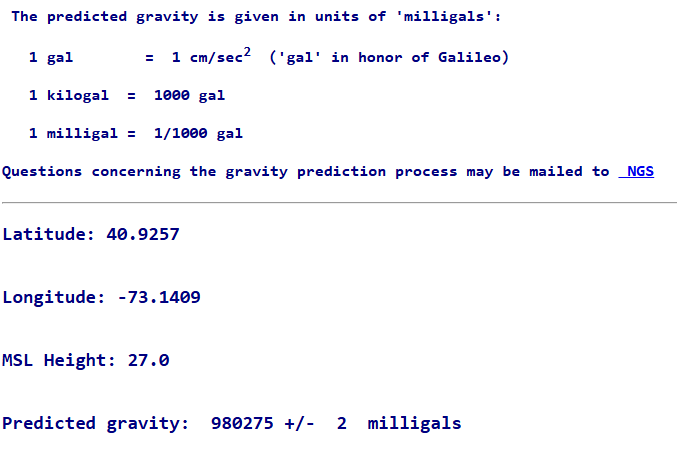

In [85]:
from IPython.display import Image

Image("/content/Screenshot 2025-05-16 080321.png")


## Comparison with Local Gravitational Acceleration

The predicted local gravitational acceleration from the NOAA Geoid Calculator is:

- **NOAA value**:  
  \( g = 980275 \pm 2 \) milligals  
  \( \Rightarrow 9.80275 \pm 0.00002 \ \text{m/s}^2 \)

The experimentally determined value from the pendulum fit was:

- **Experimental value**:  
  \( g = 12.98 \pm 0.21 \ \text{m/s}^2 \)

The difference is:

- \( \Delta g = 12.98 - 9.80275 = 3.18 \ \text{m/s}^2 \)
- Percent error:  
  \( \frac{3.18}{9.80275} \times 100 \approx 32.4\% \)

## Sources of Discrepancy

Several factors may explain the large difference between the experimental and expected values:

- **Sensor misalignment**: The phone may not have been perfectly aligned with the motion of the pendulum, leading to under- or overestimation of linear acceleration.
- **Model oversimplification**: The damped cosine model assumes small-angle behavior. At larger angles, the true motion deviates from the ideal simple harmonic approximation.
- **Initial conditions**: The fit focused on the initial part of the motion where damping is strongest and nonlinear effects are more significant.
- **Sensor limitations**: Resolution limits, sampling rate, and sensor noise in the accelerometer data could distort the measured frequency.
- **Air resistance and friction**: These effects contribute to energy loss and may also slightly affect the period, especially in the early motion.
